In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import integrate
import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform

import matplotlib.pyplot as plt

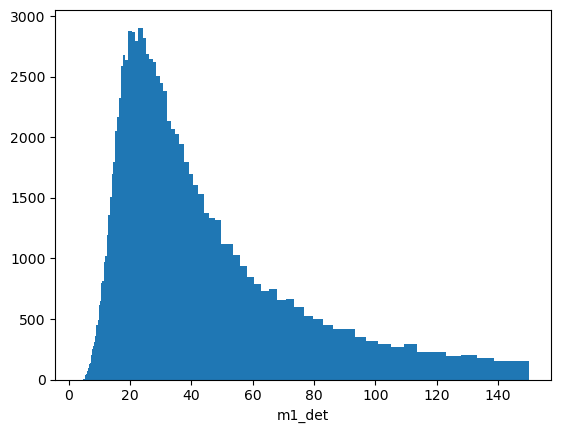

In [2]:
input_file = '../output/smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

m1s = conv.mass1_from_mchirp_eta(Mcs, etas)
mtotals = conv.mtotal_from_mchirp_eta(Mcs, etas)
f_highs = np.round(4*br.f_isco_Msolar(mtotals))


plt.hist(m1s, bins = np.geomspace(3.0, 150.0, 100))
plt.xlabel('m1_det')
plt.show()


# Optimize Phic, tc using Matched Filter

In [3]:
def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))


In [4]:
binary_i = 47519 # 'Pessimistic' Binary
offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
    'Mc':    Mcs[binary_i+offset],
    'eta':   etas[binary_i+offset],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[binary_i+offset],
    'chi2z': chi2z[binary_i+offset],
    'DL':    DLs[binary_i+offset],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[binary_i+offset],
    'ra':    ras[binary_i+offset],
    'dec':   decs[binary_i+offset],
    'psi':   psis[binary_i+offset],
    'gmst0': 0,
    'hybr': 0.0
    } 


net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

net_ap = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx2, network_key=net_key, calc_detector_responses=True, calc_derivs=True, calc_fisher=True)

2024-01-05 15:12:37,283 - Network - INFO : Polarizations calculated.


2024-01-05 15:12:37,490 - Network - INFO : PSDs loaded.
2024-01-05 15:12:37,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:12:39,581 - Network - INFO : Detector responses calculated.
2024-01-05 15:12:39,583 - Network - INFO : SNRs calculated.
2024-01-05 15:12:39,882 - Network - INFO : Polarizations calculated.
2024-01-05 15:12:39,883 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 15:12:40,382 - Network - INFO : Polarizations calculated.
2024-01-05 15:13:07,283 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 15:13:07,382 - Network - INFO : PSDs loaded.
2024-01-05 15:13:07,384 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:13:09,482 - Network - INFO : Detector responses calculated.
2024-01-05 15:13:09,483 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 15:13:09,483 - Network - INFO :    CE-40_C
2024-01-05 15:13:27,891 - Network - INFO :    CE-20_S
2

2024-01-05 15:14:41,382 - Network - INFO : Polarizations calculated.
2024-01-05 15:14:41,487 - Network - INFO : PSDs loaded.
2024-01-05 15:14:41,488 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:14:41,783 - Network - INFO : Detector responses calculated.
2024-01-05 15:14:41,783 - Network - INFO : SNRs calculated.


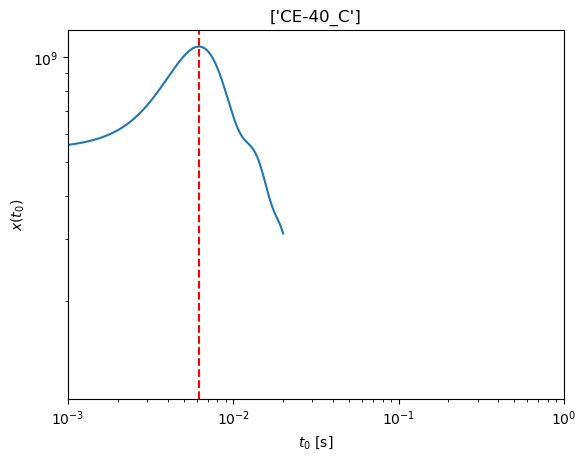

time shift: 0.006200000000000001
phase shift: 4.1015476117432605
Inner product:
0.9997479210659056


2024-01-05 15:14:44,182 - Network - INFO : Polarizations calculated.
2024-01-05 15:14:44,284 - Network - INFO : PSDs loaded.
2024-01-05 15:14:44,285 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:14:44,587 - Network - INFO : Detector responses calculated.
2024-01-05 15:14:44,588 - Network - INFO : SNRs calculated.


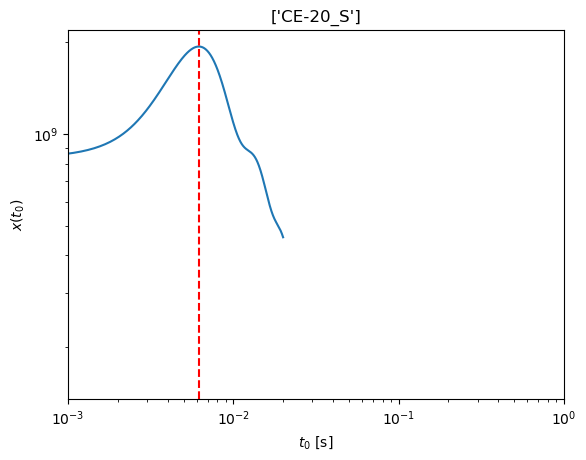

time shift: 0.006200000000000001
phase shift: 4.100300287816237
Inner product:
0.9996952671742146


2024-01-05 15:14:47,083 - Network - INFO : Polarizations calculated.
2024-01-05 15:14:47,191 - Network - INFO : PSDs loaded.
2024-01-05 15:14:47,192 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:14:47,284 - Network - INFO : Detector responses calculated.
2024-01-05 15:14:47,481 - Network - INFO : SNRs calculated.


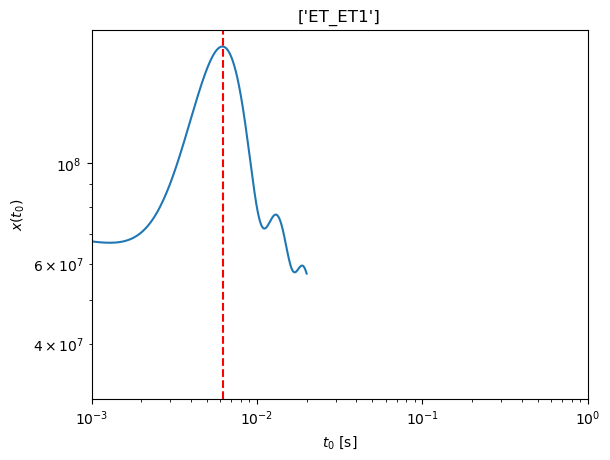

time shift: 0.006200000000000001
phase shift: 4.104396590430023
Inner product:
0.9996538874321885


2024-01-05 15:14:50,482 - Network - INFO : Polarizations calculated.
2024-01-05 15:14:50,591 - Network - INFO : PSDs loaded.
2024-01-05 15:14:50,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:14:50,882 - Network - INFO : Detector responses calculated.
2024-01-05 15:14:50,883 - Network - INFO : SNRs calculated.


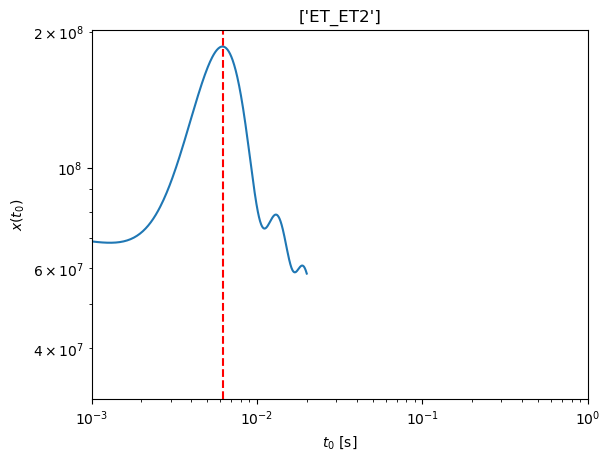

time shift: 0.006200000000000001
phase shift: 4.104396590430023
Inner product:
0.9996538874321884


2024-01-05 15:14:53,582 - Network - INFO : Polarizations calculated.
2024-01-05 15:14:53,782 - Network - INFO : PSDs loaded.
2024-01-05 15:14:53,783 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:14:54,083 - Network - INFO : Detector responses calculated.
2024-01-05 15:14:54,084 - Network - INFO : SNRs calculated.


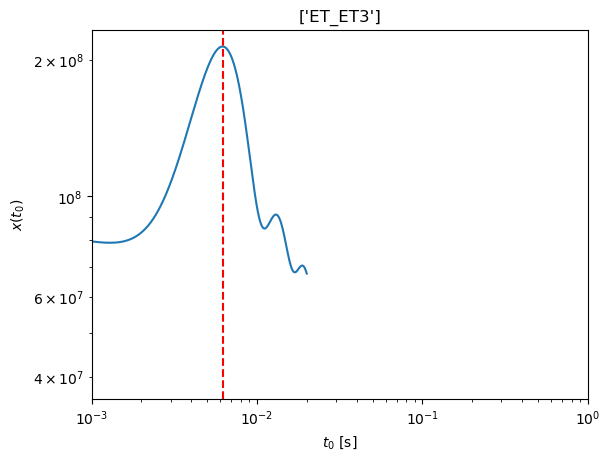

time shift: 0.006200000000000001
phase shift: 4.104396590430023
Inner product:
0.9996538874321883


In [5]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

# Limit the time window to precisely search for t_0
# time_arr_d = np.linspace(0.0002, 0.02, 12001)
time_arr_d = np.linspace(-0.02, 0.02, 1001)


for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_true.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    Sn = net_ap.detectors[d].psd
    f = net_ap.detectors[d].f
    network_spec_d = [net_ap.detectors[d].det_key]

    # Set up Matched Filter 
    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i_t in range(len(time_arr_d)):
        t0 = time_arr_d[i_t]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i_t] = np.real(x_t0_d)
        x_t0_im_d[i_t] = np.imag(x_t0_d)

    # Find time that maximizes overlap
    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d
    inj_params_opt_d['phic'] = phase_shift_d 

    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], approximant=approx1, network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

    #  ## Sanity Checks to make sure the correct phase and time shifts are being applied
    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-3, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)
    print("Inner product:")
    # print(net_ap.detectors[d].f.shape)
    # print(net_tr_opt_d.detectors[0].f.shape)
    print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - h2
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, Sn, f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

Mc: -4.970 sigma
eta: -1.337 sigma
chi1z: 3.659 sigma
chi2z: -3.663 sigma
DL: 0.274 sigma
tc: -3.248 sigma
phic: -2.455 sigma
iota: -0.523 sigma
ra: 0.114 sigma
dec: 0.002 sigma
psi: -0.842 sigma


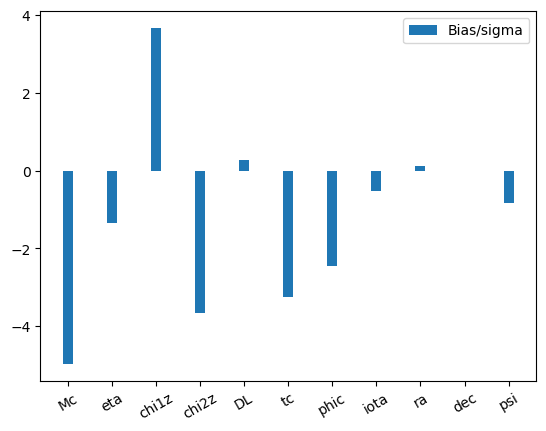

In [6]:
cv_bias_sigma = np.zeros(len(cv_bias_opt))

for i, var in enumerate(net_ap.deriv_variables):
    cv_bias_sigma[i] = cv_bias_opt[i]/net_ap.errs[var]
    print(f"{net_ap.deriv_variables[i]}: {cv_bias_opt[i]/net_ap.errs[var]:.3f} sigma")


bias1 = cv_bias_sigma

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias/sigma')

plt.xticks(x, net_ap.deriv_variables, rotation=30)

plt.legend()
plt.show()


# Hybrid Waveform Test

In [7]:
binary_i = 47519 # 'Pessimistic' Binary
offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'



inj_params_hyb = {
    'Mc':    Mcs[binary_i+offset],
    'eta':   etas[binary_i+offset],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[binary_i+offset],
    'chi2z': chi2z[binary_i+offset],
    'DL':    DLs[binary_i+offset],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[binary_i+offset],
    'ra':    ras[binary_i+offset],
    'dec':   decs[binary_i+offset],
    'psi':   psis[binary_i+offset],
    'gmst0': 0,
    'hybr': 0.3
    } 


net_true = gwnet.get_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)


net_ap_hyb = gwnet.get_hybrid_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], 
    approximant1=approx1, approximant2=approx2, 
    network_key=net_key, calc_detector_responses=True, calc_derivs=True, calc_fisher=True)

2024-01-05 15:14:56,082 - Network - INFO : Polarizations calculated.


2024-01-05 15:14:56,299 - Network - INFO : PSDs loaded.
2024-01-05 15:14:56,381 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:14:58,182 - Network - INFO : Detector responses calculated.
2024-01-05 15:14:58,185 - Network - INFO : SNRs calculated.
2024-01-05 15:14:58,983 - Network - INFO : Polarizations calculated.
2024-01-05 15:14:58,983 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 15:14:59,583 - Network - INFO : Polarizations calculated.
2024-01-05 15:15:49,511 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 15:15:49,685 - Network - INFO : PSDs loaded.
2024-01-05 15:15:49,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:15:53,283 - Network - INFO : Detector responses calculated.
2024-01-05 15:15:53,285 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 15:15:53,285 - Network - INFO :    CE-40_C
2024-01-05 15:16:28,309 - Network - INFO :    CE-20_S
2

2024-01-05 15:20:00,682 - Network - INFO : Polarizations calculated.
2024-01-05 15:20:00,781 - Network - INFO : PSDs loaded.
2024-01-05 15:20:00,782 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:20:01,083 - Network - INFO : Detector responses calculated.
2024-01-05 15:20:01,083 - Network - INFO : SNRs calculated.


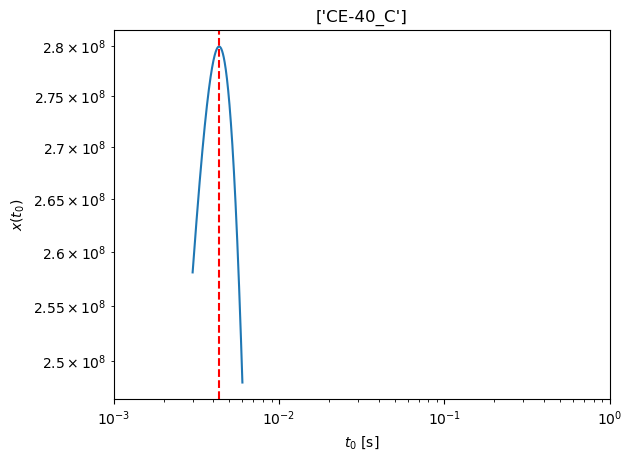

time shift: 0.004338
phase shift: -0.8190960163371371
Inner product:
0.9998764428458341


2024-01-05 15:20:03,882 - Network - INFO : Polarizations calculated.
2024-01-05 15:20:03,984 - Network - INFO : PSDs loaded.
2024-01-05 15:20:03,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:20:04,383 - Network - INFO : Detector responses calculated.
2024-01-05 15:20:04,383 - Network - INFO : SNRs calculated.


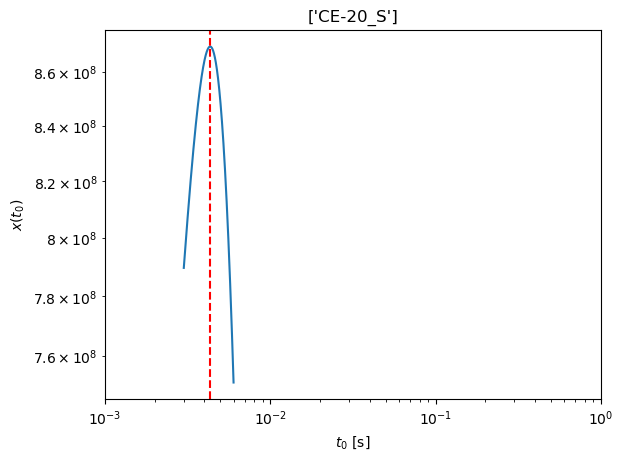

time shift: 0.004332
phase shift: -1.079774572425505
Inner product:
0.9998522629160252


2024-01-05 15:20:07,682 - Network - INFO : Polarizations calculated.
2024-01-05 15:20:07,790 - Network - INFO : PSDs loaded.
2024-01-05 15:20:07,791 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:20:08,183 - Network - INFO : Detector responses calculated.
2024-01-05 15:20:08,183 - Network - INFO : SNRs calculated.


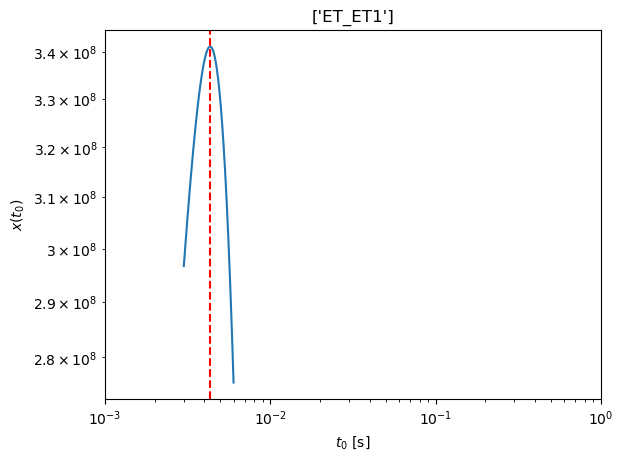

time shift: 0.004332
phase shift: -2.6895276333717364
Inner product:
0.9998336562397057


2024-01-05 15:20:10,782 - Network - INFO : Polarizations calculated.
2024-01-05 15:20:10,983 - Network - INFO : PSDs loaded.
2024-01-05 15:20:10,984 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:20:11,383 - Network - INFO : Detector responses calculated.
2024-01-05 15:20:11,384 - Network - INFO : SNRs calculated.


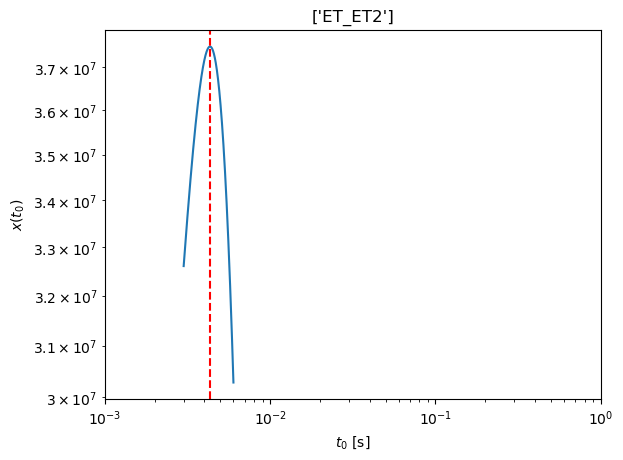

time shift: 0.004332
phase shift: 2.03944362091302
Inner product:
0.9998336562397054


2024-01-05 15:20:14,182 - Network - INFO : Polarizations calculated.
2024-01-05 15:20:14,381 - Network - INFO : PSDs loaded.
2024-01-05 15:20:14,382 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 15:20:14,783 - Network - INFO : Detector responses calculated.
2024-01-05 15:20:14,784 - Network - INFO : SNRs calculated.


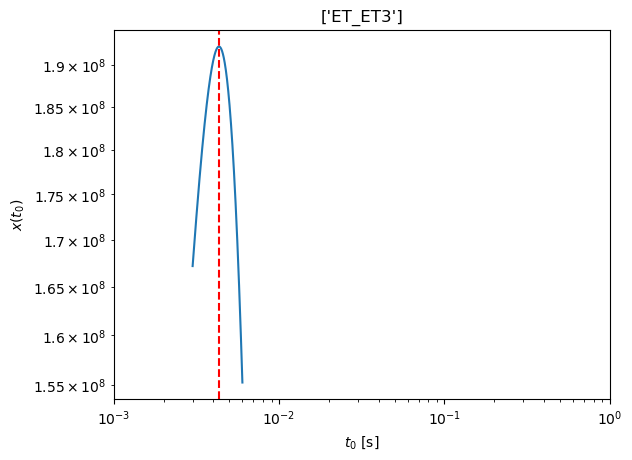

time shift: 0.004332
phase shift: -1.455577532295432
Inner product:
0.9998336562397055


In [11]:
overlap_vecs_network = np.zeros((len(net_ap_hyb.detectors), len(net_ap_hyb.deriv_variables)))

# Limit the time window to precisely search for t_0
time_arr_d = np.linspace(-0.02, 0.02, 1001)


for d in range(len(net_ap_hyb.detectors)):

    ## set up initial waveforms
    h1 = net_true.detectors[d].hf
    h2 = net_ap_hyb.detectors[d].hf
    Sn = net_ap_hyb.detectors[d].psd
    f = net_ap_hyb.detectors[d].f
    network_spec_d = [net_ap_hyb.detectors[d].det_key]

    # Set up Matched Filter 
    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i_t in range(len(time_arr_d)):
        t0 = time_arr_d[i_t]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i_t] = np.real(x_t0_d)
        x_t0_im_d[i_t] = np.imag(x_t0_d)

    # Find time that maximizes overlap
    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d
    inj_params_opt_d['phic'] = phase_shift_d 

    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], 
    approximant=approx1,
    network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

    #  ## Sanity Checks to make sure the correct phase and time shifts are being applied
    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-3, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)
    print("Inner product:")
    print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - h2
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap_hyb.detectors[d].del_hf, delta_hf, Sn, f)

cv_bias_opt_hybr = np.matmul(net_ap_hyb.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt_hybr = np.array(cv_bias_opt_hybr.tolist()[0])

def: Mc: -4.970 sigma
hyb: Mc: -12.100 sigma

def: eta: -1.337 sigma
hyb: eta: -2.981 sigma

def: chi1z: 3.659 sigma
hyb: chi1z: 6.570 sigma

def: chi2z: -3.663 sigma
hyb: chi2z: -6.572 sigma

def: DL: 0.274 sigma
hyb: DL: 2174.687 sigma

def: tc: -3.248 sigma
hyb: tc: -4.249 sigma

def: phic: -2.455 sigma
hyb: phic: 19.949 sigma

def: iota: -0.523 sigma
hyb: iota: -2057.981 sigma

def: ra: 0.114 sigma
hyb: ra: 35.128 sigma

def: dec: 0.002 sigma
hyb: dec: 35.487 sigma

def: psi: -0.842 sigma
hyb: psi: -94.628 sigma



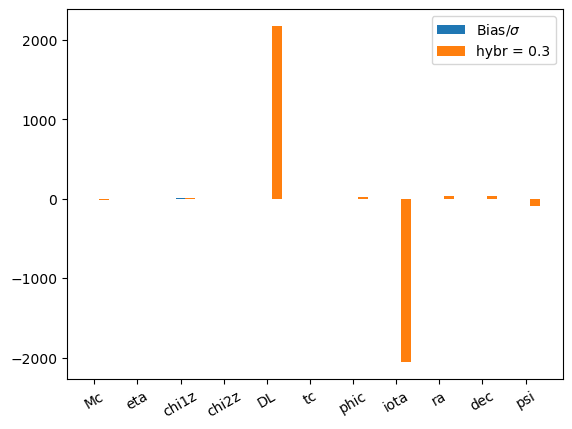

In [13]:
cv_bias_sigma = np.zeros(len(cv_bias_opt))
cv_bias_hybr_sigma = np.zeros(len(cv_bias_opt))

for i, var in enumerate(net_ap.deriv_variables):
    cv_bias_sigma[i] = cv_bias_opt[i]/net_ap.errs[var]
    cv_bias_hybr_sigma[i] = cv_bias_opt_hybr[i]/net_ap.errs[var]

    print(f"def: {net_ap.deriv_variables[i]}: {cv_bias_opt[i]/net_ap.errs[var]:.3f} sigma")
    print(f"hyb: {net_ap.deriv_variables[i]}: {cv_bias_opt_hybr[i]/net_ap.errs[var]:.3f} sigma")
    print()


bias1 = cv_bias_sigma
bias2 = cv_bias_hybr_sigma

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias/$\sigma$')
plt.bar(x+width, bias2, width=width, label=f"hybr = {inj_params_hyb['hybr']}")

plt.xticks(x, net_ap.deriv_variables, rotation=30)

plt.legend()
plt.show()


## Bias vs Hybr

In [57]:
binary_i = 47519 # 'Pessimistic' Binary
offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
        'Mc':    Mcs[binary_i+offset],
        'eta':   etas[binary_i+offset],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[binary_i+offset],
        'chi2z': chi2z[binary_i+offset],
        'DL':    DLs[binary_i+offset],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[binary_i+offset],
        'ra':    ras[binary_i+offset],
        'dec':   decs[binary_i+offset],
        'psi':   psis[binary_i+offset],
        'gmst0': 0,
        'hybr': 0.0
        } 

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

2024-01-05 13:52:44,483 - Network - INFO : Polarizations calculated.


2024-01-05 13:52:44,981 - Network - INFO : PSDs loaded.
2024-01-05 13:52:44,983 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 13:52:46,682 - Network - INFO : Detector responses calculated.
2024-01-05 13:52:46,685 - Network - INFO : SNRs calculated.


In [72]:
hybr_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # takes ~3.5 min per hybr
cv_bias_opt_hybr_all = np.zeros((len(hybr_range), len(cv_bias_opt)))

for h, hybr in enumerate(hybr_range):
    print("hybr: ", hybr)

    inj_params_hyb = inj_params.copy()
    inj_params_hyb['hybr'] = hybr

    net_ap_hyb = gwnet.get_hybrid_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], 
        approximant1=approx1, approximant2=approx2, 
        network_key=net_key, calc_detector_responses=True, calc_derivs=True, calc_fisher=True)
        

    # Find the CV Bias    
    overlap_vecs_network = np.zeros((len(net_ap_hyb.detectors), len(net_ap_hyb.deriv_variables)))
    # Limit the time window to precisely search for t_0
    time_arr_d = np.linspace(-0.02, 0.02, 1001)


    for d in range(len(net_ap_hyb.detectors)):

        ## set up initial waveforms
        h1 = net_true.detectors[d].hf
        h2 = net_ap_hyb.detectors[d].hf
        Sn = net_ap_hyb.detectors[d].psd
        f = net_ap_hyb.detectors[d].f
        network_spec_d = [net_ap_hyb.detectors[d].det_key]

        # Set up Matched Filter 
        x_t0_re_d = np.zeros(len(time_arr_d))
        x_t0_im_d = np.zeros(len(time_arr_d))

        for i_t in range(len(time_arr_d)):
            t0 = time_arr_d[i_t]
            x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
            x_t0_re_d[i_t] = np.real(x_t0_d)
            x_t0_im_d[i_t] = np.imag(x_t0_d)

        # Find time that maximizes overlap
        max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
        time_shift_d = time_arr_d[max_idx]
        phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

        inj_params_opt_d = inj_params.copy()
        inj_params_opt_d['tc'] = time_shift_d
        inj_params_opt_d['phic'] = phase_shift_d 

        net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], 
        approximant=approx1,
        network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

        #  ## Sanity Checks to make sure the correct phase and time shifts are being applied
        # plt.title(network_spec_d)
        # plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
        # plt.axvline(x=time_shift_d, ls='--', c='r')
        # plt.xlabel('$t_0$ [s]')
        # plt.ylabel("$x(t_0)$")
        # plt.loglog()
        # plt.xlim(1e-3, 1e0)
        # plt.show()
        print("time shift:", time_shift_d)
        print("phase shift:", phase_shift_d)
        print("Inner product:")
        # print(net_ap_hyb.detectors[d].f.shape)
        # print(net_tr_opt_d.detectors[0].f.shape)
        print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

        ## Compute CV overlap vector for this detector
        delta_hf = net_tr_opt_d.detectors[0].hf - h2
        overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap_hyb.detectors[d].del_hf, delta_hf, Sn, f)

    cv_bias_opt_hybr = np.matmul(net_ap_hyb.cov, np.sum(overlap_vecs_network, axis=0))
    cv_bias_opt_hybr_all[h] = np.array(cv_bias_opt_hybr.tolist()[0])

hybr:  0.0


2024-01-05 14:09:07,281 - Network - INFO : Polarizations calculated.
2024-01-05 14:09:07,282 - Network - INFO : Calculate numeric derivatives of polarizations.


2024-01-05 14:09:07,884 - Network - INFO : Polarizations calculated.
2024-01-05 14:09:49,780 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:09:49,898 - Network - INFO : PSDs loaded.
2024-01-05 14:09:49,899 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:09:52,883 - Network - INFO : Detector responses calculated.
2024-01-05 14:09:52,884 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:09:52,884 - Network - INFO :    CE-40_C
2024-01-05 14:10:22,396 - Network - INFO :    CE-20_S
2024-01-05 14:10:53,881 - Network - INFO :    ET_ET1
2024-01-05 14:11:24,304 - Network - INFO :    ET_ET2
2024-01-05 14:11:53,499 - Network - INFO :    ET_ET3
2024-01-05 14:12:23,497 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 14:12:23,499 - Network - INFO : SNRs calculated.
2024-01-05 14:12:23,580 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-05 14:12:23,581 - N

time shift: 0.006200000000000001
phase shift: 4.101547611743214
Inner product:
0.9997479210659052


2024-01-05 14:12:28,782 - Network - INFO : Polarizations calculated.
2024-01-05 14:12:28,788 - Network - INFO : PSDs loaded.
2024-01-05 14:12:28,788 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:12:29,183 - Network - INFO : Detector responses calculated.
2024-01-05 14:12:29,183 - Network - INFO : SNRs calculated.


time shift: 0.006200000000000001
phase shift: 4.100300287816188
Inner product:
0.9996952671742146


2024-01-05 14:12:31,383 - Network - INFO : Polarizations calculated.
2024-01-05 14:12:31,590 - Network - INFO : PSDs loaded.
2024-01-05 14:12:31,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:12:31,983 - Network - INFO : Detector responses calculated.
2024-01-05 14:12:31,984 - Network - INFO : SNRs calculated.


time shift: 0.006200000000000001
phase shift: 4.104396590429991
Inner product:
0.999653887432188


2024-01-05 14:12:35,383 - Network - INFO : Polarizations calculated.
2024-01-05 14:12:35,582 - Network - INFO : PSDs loaded.
2024-01-05 14:12:35,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:12:35,883 - Network - INFO : Detector responses calculated.
2024-01-05 14:12:35,883 - Network - INFO : SNRs calculated.


time shift: 0.006200000000000001
phase shift: 4.104396590429991
Inner product:
0.9996538874321883


2024-01-05 14:12:38,284 - Network - INFO : Polarizations calculated.
2024-01-05 14:12:38,482 - Network - INFO : PSDs loaded.
2024-01-05 14:12:38,483 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:12:38,883 - Network - INFO : Detector responses calculated.
2024-01-05 14:12:38,884 - Network - INFO : SNRs calculated.


time shift: 0.006200000000000001
phase shift: 4.104396590429991
Inner product:
0.9996538874321881
hybr:  0.1


2024-01-05 14:12:39,881 - Network - INFO : Polarizations calculated.
2024-01-05 14:12:39,881 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:12:40,681 - Network - INFO : Polarizations calculated.
2024-01-05 14:13:23,882 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:13:24,086 - Network - INFO : PSDs loaded.
2024-01-05 14:13:24,088 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:13:26,783 - Network - INFO : Detector responses calculated.
2024-01-05 14:13:26,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:13:26,785 - Network - INFO :    CE-40_C
2024-01-05 14:13:55,496 - Network - INFO :    CE-20_S
2024-01-05 14:14:24,891 - Network - INFO :    ET_ET1
2024-01-05 14:14:53,996 - Network - INFO :    ET_ET2
2024-01-05 14:15:24,193 - Network - INFO :    ET_ET3
2024-01-05 14:15:53,390 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.0055600000000000024
phase shift: 4.26815168519489
Inner product:
0.9997888826917016


2024-01-05 14:15:59,782 - Network - INFO : Polarizations calculated.
2024-01-05 14:15:59,884 - Network - INFO : PSDs loaded.
2024-01-05 14:15:59,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:16:00,184 - Network - INFO : Detector responses calculated.
2024-01-05 14:16:00,280 - Network - INFO : SNRs calculated.


time shift: 0.0055600000000000024
phase shift: 4.314679927220608
Inner product:
0.9997532841261848


2024-01-05 14:16:03,182 - Network - INFO : Polarizations calculated.
2024-01-05 14:16:03,382 - Network - INFO : PSDs loaded.
2024-01-05 14:16:03,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:16:03,682 - Network - INFO : Detector responses calculated.
2024-01-05 14:16:03,683 - Network - INFO : SNRs calculated.


time shift: 0.0055600000000000024
phase shift: 3.9112592642562793
Inner product:
0.9997230345240238


2024-01-05 14:16:05,982 - Network - INFO : Polarizations calculated.
2024-01-05 14:16:06,089 - Network - INFO : PSDs loaded.
2024-01-05 14:16:06,090 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:16:06,483 - Network - INFO : Detector responses calculated.
2024-01-05 14:16:06,484 - Network - INFO : SNRs calculated.


time shift: 0.0055600000000000024
phase shift: 3.764855685817398
Inner product:
0.9997230345240232


2024-01-05 14:16:08,882 - Network - INFO : Polarizations calculated.
2024-01-05 14:16:10,191 - Network - INFO : PSDs loaded.
2024-01-05 14:16:10,192 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:16:10,483 - Network - INFO : Detector responses calculated.
2024-01-05 14:16:10,484 - Network - INFO : SNRs calculated.


time shift: 0.0055600000000000024
phase shift: 4.32640041673662
Inner product:
0.9997230345240234
hybr:  0.2


2024-01-05 14:16:11,181 - Network - INFO : Polarizations calculated.
2024-01-05 14:16:11,182 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:16:11,781 - Network - INFO : Polarizations calculated.
2024-01-05 14:16:51,695 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:16:51,894 - Network - INFO : PSDs loaded.
2024-01-05 14:16:51,895 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:16:54,783 - Network - INFO : Detector responses calculated.
2024-01-05 14:16:54,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:16:54,784 - Network - INFO :    CE-40_C
2024-01-05 14:17:24,485 - Network - INFO :    CE-20_S
2024-01-05 14:17:56,792 - Network - INFO :    ET_ET1
2024-01-05 14:18:30,990 - Network - INFO :    ET_ET2
2024-01-05 14:19:01,291 - Network - INFO :    ET_ET3
2024-01-05 14:19:31,602 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.004960000000000003
phase shift: 4.719422308140047
Inner product:
0.9998385573994479


2024-01-05 14:19:36,982 - Network - INFO : Polarizations calculated.
2024-01-05 14:19:36,988 - Network - INFO : PSDs loaded.
2024-01-05 14:19:36,989 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:19:37,383 - Network - INFO : Detector responses calculated.
2024-01-05 14:19:37,480 - Network - INFO : SNRs calculated.


time shift: 0.004960000000000003
phase shift: 4.705243837121142
Inner product:
0.9998048789528499


2024-01-05 14:19:39,583 - Network - INFO : Polarizations calculated.
2024-01-05 14:19:39,783 - Network - INFO : PSDs loaded.
2024-01-05 14:19:39,784 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:19:40,083 - Network - INFO : Detector responses calculated.
2024-01-05 14:19:40,084 - Network - INFO : SNRs calculated.


time shift: 0.004960000000000003
phase shift: 3.7526013537760194
Inner product:
0.9997783085741425


2024-01-05 14:19:42,582 - Network - INFO : Polarizations calculated.
2024-01-05 14:19:42,683 - Network - INFO : PSDs loaded.
2024-01-05 14:19:42,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:19:42,983 - Network - INFO : Detector responses calculated.
2024-01-05 14:19:42,984 - Network - INFO : SNRs calculated.


time shift: 0.004960000000000003
phase shift: 3.1200883757201976
Inner product:
0.9997783085741425


2024-01-05 14:19:45,282 - Network - INFO : Polarizations calculated.
2024-01-05 14:19:45,484 - Network - INFO : PSDs loaded.
2024-01-05 14:19:45,485 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:19:45,783 - Network - INFO : Detector responses calculated.
2024-01-05 14:19:45,784 - Network - INFO : SNRs calculated.


time shift: 0.004960000000000003
phase shift: 4.576468355687115
Inner product:
0.9997783085741426
hybr:  0.3


2024-01-05 14:19:46,381 - Network - INFO : Polarizations calculated.
2024-01-05 14:19:46,381 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:19:46,884 - Network - INFO : Polarizations calculated.
2024-01-05 14:20:33,897 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:20:34,090 - Network - INFO : PSDs loaded.
2024-01-05 14:20:34,092 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:20:37,581 - Network - INFO : Detector responses calculated.
2024-01-05 14:20:37,581 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:20:37,582 - Network - INFO :    CE-40_C
2024-01-05 14:21:10,691 - Network - INFO :    CE-20_S
2024-01-05 14:21:41,783 - Network - INFO :    ET_ET1
2024-01-05 14:22:15,889 - Network - INFO :    ET_ET2
2024-01-05 14:22:44,498 - Network - INFO :    ET_ET3
2024-01-05 14:23:15,083 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.004320000000000001
phase shift: 5.460110775180399
Inner product:
0.9998688545384118


2024-01-05 14:23:20,982 - Network - INFO : Polarizations calculated.
2024-01-05 14:23:21,083 - Network - INFO : PSDs loaded.
2024-01-05 14:23:21,084 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:23:21,582 - Network - INFO : Detector responses calculated.
2024-01-05 14:23:21,583 - Network - INFO : SNRs calculated.


time shift: 0.004320000000000001
phase shift: 5.20040158266514
Inner product:
0.999848150613708


2024-01-05 14:23:24,486 - Network - INFO : Polarizations calculated.
2024-01-05 14:23:24,589 - Network - INFO : PSDs loaded.
2024-01-05 14:23:24,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:23:24,883 - Network - INFO : Detector responses calculated.
2024-01-05 14:23:24,884 - Network - INFO : SNRs calculated.


time shift: 0.004320000000000001
phase shift: 3.590827749455923
Inner product:
0.9998292405528895


2024-01-05 14:23:27,282 - Network - INFO : Polarizations calculated.
2024-01-05 14:23:27,483 - Network - INFO : PSDs loaded.
2024-01-05 14:23:27,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:23:27,783 - Network - INFO : Detector responses calculated.
2024-01-05 14:23:27,784 - Network - INFO : SNRs calculated.


time shift: 0.004320000000000001
phase shift: 2.0366136965610933
Inner product:
0.9998292405528892


2024-01-05 14:23:29,883 - Network - INFO : Polarizations calculated.
2024-01-05 14:23:30,186 - Network - INFO : PSDs loaded.
2024-01-05 14:23:30,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:23:30,582 - Network - INFO : Detector responses calculated.
2024-01-05 14:23:30,583 - Network - INFO : SNRs calculated.


time shift: 0.004320000000000001
phase shift: -1.4584074566473586
Inner product:
0.9998292405528892
hybr:  0.4


2024-01-05 14:23:31,481 - Network - INFO : Polarizations calculated.
2024-01-05 14:23:31,482 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:23:32,081 - Network - INFO : Polarizations calculated.
2024-01-05 14:24:12,596 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:24:12,695 - Network - INFO : PSDs loaded.
2024-01-05 14:24:12,697 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:24:15,481 - Network - INFO : Detector responses calculated.
2024-01-05 14:24:15,481 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:24:15,482 - Network - INFO :    CE-40_C
2024-01-05 14:24:42,095 - Network - INFO :    CE-20_S
2024-01-05 14:25:08,891 - Network - INFO :    ET_ET1
2024-01-05 14:25:35,786 - Network - INFO :    ET_ET2
2024-01-05 14:26:05,385 - Network - INFO :    ET_ET3
2024-01-05 14:26:31,087 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.003720000000000001
phase shift: -0.37179850495498723
Inner product:
0.9999091274552344


2024-01-05 14:26:34,281 - Network - INFO : Polarizations calculated.
2024-01-05 14:26:34,287 - Network - INFO : PSDs loaded.
2024-01-05 14:26:34,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:26:34,582 - Network - INFO : Detector responses calculated.
2024-01-05 14:26:34,583 - Network - INFO : SNRs calculated.


time shift: 0.003720000000000001
phase shift: 5.590971506928212
Inner product:
0.9998901952779649


2024-01-05 14:26:36,082 - Network - INFO : Polarizations calculated.
2024-01-05 14:26:36,093 - Network - INFO : PSDs loaded.
2024-01-05 14:26:36,094 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:26:36,383 - Network - INFO : Detector responses calculated.
2024-01-05 14:26:36,384 - Network - INFO : SNRs calculated.


time shift: 0.003720000000000001
phase shift: 3.432175719840194
Inner product:
0.9998752007481051


2024-01-05 14:26:37,882 - Network - INFO : Polarizations calculated.
2024-01-05 14:26:37,990 - Network - INFO : PSDs loaded.
2024-01-05 14:26:37,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:26:38,283 - Network - INFO : Detector responses calculated.
2024-01-05 14:26:38,380 - Network - INFO : SNRs calculated.


time shift: 0.003720000000000001
phase shift: 1.3918522673284242
Inner product:
0.999875200748105


2024-01-05 14:26:39,782 - Network - INFO : Polarizations calculated.
2024-01-05 14:26:39,890 - Network - INFO : PSDs loaded.
2024-01-05 14:26:39,890 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:26:40,183 - Network - INFO : Detector responses calculated.
2024-01-05 14:26:40,184 - Network - INFO : SNRs calculated.


time shift: 0.003720000000000001
phase shift: -1.2083336368323332
Inner product:
0.9998752007481051
hybr:  0.5


2024-01-05 14:26:40,784 - Network - INFO : Polarizations calculated.
2024-01-05 14:26:40,786 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:26:41,484 - Network - INFO : Polarizations calculated.
2024-01-05 14:27:20,491 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:27:20,594 - Network - INFO : PSDs loaded.
2024-01-05 14:27:20,596 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:27:24,384 - Network - INFO : Detector responses calculated.
2024-01-05 14:27:24,384 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:27:24,385 - Network - INFO :    CE-40_C
2024-01-05 14:27:51,393 - Network - INFO :    CE-20_S
2024-01-05 14:28:18,097 - Network - INFO :    ET_ET1
2024-01-05 14:28:45,504 - Network - INFO :    ET_ET2
2024-01-05 14:29:11,890 - Network - INFO :    ET_ET3
2024-01-05 14:29:37,489 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.003080000000000003
phase shift: -0.20518664365609254
Inner product:
0.9999287913653455


2024-01-05 14:29:40,882 - Network - INFO : Polarizations calculated.
2024-01-05 14:29:40,984 - Network - INFO : PSDs loaded.
2024-01-05 14:29:40,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:29:41,283 - Network - INFO : Detector responses calculated.
2024-01-05 14:29:41,283 - Network - INFO : SNRs calculated.


time shift: 0.003080000000000003
phase shift: -0.47782405806694545
Inner product:
0.9999187647091623


2024-01-05 14:29:42,782 - Network - INFO : Polarizations calculated.
2024-01-05 14:29:42,890 - Network - INFO : PSDs loaded.
2024-01-05 14:29:42,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:29:43,181 - Network - INFO : Detector responses calculated.
2024-01-05 14:29:43,182 - Network - INFO : SNRs calculated.


time shift: 0.003080000000000003
phase shift: 3.239050453189902
Inner product:
0.9999079589046339


2024-01-05 14:29:44,312 - Network - INFO : Polarizations calculated.
2024-01-05 14:29:44,685 - Network - INFO : PSDs loaded.
2024-01-05 14:29:44,686 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:29:44,981 - Network - INFO : Detector responses calculated.
2024-01-05 14:29:44,982 - Network - INFO : SNRs calculated.


time shift: 0.003080000000000003
phase shift: 1.0523234222392497
Inner product:
0.9999079589046338


2024-01-05 14:29:46,382 - Network - INFO : Polarizations calculated.
2024-01-05 14:29:46,489 - Network - INFO : PSDs loaded.
2024-01-05 14:29:46,490 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:29:46,783 - Network - INFO : Detector responses calculated.
2024-01-05 14:29:46,784 - Network - INFO : SNRs calculated.


time shift: 0.003080000000000003
phase shift: -0.9863177510022844
Inner product:
0.9999079589046341
hybr:  0.6


2024-01-05 14:29:47,384 - Network - INFO : Polarizations calculated.
2024-01-05 14:29:47,384 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:29:47,880 - Network - INFO : Polarizations calculated.
2024-01-05 14:30:26,387 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:30:26,490 - Network - INFO : PSDs loaded.
2024-01-05 14:30:26,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:30:28,883 - Network - INFO : Detector responses calculated.
2024-01-05 14:30:28,884 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:30:28,884 - Network - INFO :    CE-40_C
2024-01-05 14:30:54,490 - Network - INFO :    CE-20_S
2024-01-05 14:31:20,692 - Network - INFO :    ET_ET1
2024-01-05 14:31:46,986 - Network - INFO :    ET_ET2
2024-01-05 14:32:13,885 - Network - INFO :    ET_ET3
2024-01-05 14:32:40,212 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.002480000000000003
phase shift: -0.13492443409339824
Inner product:
0.9999595859280612


2024-01-05 14:32:43,494 - Network - INFO : Polarizations calculated.
2024-01-05 14:32:43,785 - Network - INFO : PSDs loaded.
2024-01-05 14:32:43,785 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:32:44,083 - Network - INFO : Detector responses calculated.
2024-01-05 14:32:44,084 - Network - INFO : SNRs calculated.


time shift: 0.002480000000000003
phase shift: -0.3495286939732116
Inner product:
0.9999511772369315


2024-01-05 14:32:45,003 - Network - INFO : Polarizations calculated.
2024-01-05 14:32:45,384 - Network - INFO : PSDs loaded.
2024-01-05 14:32:45,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:32:45,589 - Network - INFO : Detector responses calculated.
2024-01-05 14:32:45,681 - Network - INFO : SNRs calculated.


time shift: 0.002480000000000003
phase shift: 2.9768880105740494
Inner product:
0.9999444915577873


2024-01-05 14:32:46,502 - Network - INFO : Polarizations calculated.
2024-01-05 14:32:46,889 - Network - INFO : PSDs loaded.
2024-01-05 14:32:46,890 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:32:46,893 - Network - INFO : Detector responses calculated.
2024-01-05 14:32:47,081 - Network - INFO : SNRs calculated.


time shift: 0.002480000000000003
phase shift: 0.8226441205095868
Inner product:
0.9999444915577871


2024-01-05 14:32:48,582 - Network - INFO : Polarizations calculated.
2024-01-05 14:32:48,690 - Network - INFO : PSDs loaded.
2024-01-05 14:32:48,690 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:32:48,983 - Network - INFO : Detector responses calculated.
2024-01-05 14:32:48,983 - Network - INFO : SNRs calculated.


time shift: 0.002480000000000003
phase shift: -0.775343349578676
Inner product:
0.9999444915577873
hybr:  0.7


2024-01-05 14:32:49,580 - Network - INFO : Polarizations calculated.
2024-01-05 14:32:49,585 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:32:50,181 - Network - INFO : Polarizations calculated.
2024-01-05 14:33:29,089 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:33:29,194 - Network - INFO : PSDs loaded.
2024-01-05 14:33:29,196 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:33:31,784 - Network - INFO : Detector responses calculated.
2024-01-05 14:33:31,785 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:33:31,785 - Network - INFO :    CE-40_C
2024-01-05 14:33:57,890 - Network - INFO :    CE-20_S
2024-01-05 14:34:25,604 - Network - INFO :    ET_ET1
2024-01-05 14:34:50,983 - Network - INFO :    ET_ET2
2024-01-05 14:35:18,211 - Network - INFO :    ET_ET3
2024-01-05 14:35:44,289 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.0018400000000000014
phase shift: -0.11284787616671635
Inner product:
0.9999686504678905


2024-01-05 14:35:47,382 - Network - INFO : Polarizations calculated.
2024-01-05 14:35:47,584 - Network - INFO : PSDs loaded.
2024-01-05 14:35:47,585 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:35:47,882 - Network - INFO : Detector responses calculated.
2024-01-05 14:35:47,883 - Network - INFO : SNRs calculated.


time shift: 0.0018400000000000014
phase shift: -0.27498143476461234
Inner product:
0.9999650911205267


2024-01-05 14:35:49,103 - Network - INFO : Polarizations calculated.
2024-01-05 14:35:49,485 - Network - INFO : PSDs loaded.
2024-01-05 14:35:49,485 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:35:49,781 - Network - INFO : Detector responses calculated.
2024-01-05 14:35:49,783 - Network - INFO : SNRs calculated.


time shift: 0.0018400000000000014
phase shift: 2.3553017620567323
Inner product:
0.9999591212844133


2024-01-05 14:35:51,182 - Network - INFO : Polarizations calculated.
2024-01-05 14:35:51,290 - Network - INFO : PSDs loaded.
2024-01-05 14:35:51,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:35:51,682 - Network - INFO : Detector responses calculated.
2024-01-05 14:35:51,683 - Network - INFO : SNRs calculated.


time shift: 0.0018400000000000014
phase shift: 0.6187884756182426
Inner product:
0.9999591212844134


2024-01-05 14:35:53,082 - Network - INFO : Polarizations calculated.
2024-01-05 14:35:53,188 - Network - INFO : PSDs loaded.
2024-01-05 14:35:53,189 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:35:53,483 - Network - INFO : Detector responses calculated.
2024-01-05 14:35:53,484 - Network - INFO : SNRs calculated.


time shift: 0.0018400000000000014
phase shift: -0.5886072751164896
Inner product:
0.9999591212844133
hybr:  0.8


2024-01-05 14:35:54,284 - Network - INFO : Polarizations calculated.
2024-01-05 14:35:54,284 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:35:54,784 - Network - INFO : Polarizations calculated.
2024-01-05 14:36:34,204 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:36:34,302 - Network - INFO : PSDs loaded.
2024-01-05 14:36:34,303 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:36:36,981 - Network - INFO : Detector responses calculated.
2024-01-05 14:36:36,982 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:36:36,982 - Network - INFO :    CE-40_C
2024-01-05 14:37:03,792 - Network - INFO :    CE-20_S
2024-01-05 14:37:30,310 - Network - INFO :    ET_ET1
2024-01-05 14:37:55,789 - Network - INFO :    ET_ET2
2024-01-05 14:38:23,689 - Network - INFO :    ET_ET3
2024-01-05 14:38:50,718 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.0012400000000000015
phase shift: -0.09235320888025148
Inner product:
0.9999898901317745


2024-01-05 14:38:53,981 - Network - INFO : Polarizations calculated.
2024-01-05 14:38:53,987 - Network - INFO : PSDs loaded.
2024-01-05 14:38:53,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:38:54,383 - Network - INFO : Detector responses calculated.
2024-01-05 14:38:54,383 - Network - INFO : SNRs calculated.


time shift: 0.0012400000000000015
phase shift: -0.20285947105933133
Inner product:
0.9999877894361668


2024-01-05 14:38:55,681 - Network - INFO : Polarizations calculated.
2024-01-05 14:38:55,881 - Network - INFO : PSDs loaded.
2024-01-05 14:38:55,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:38:56,182 - Network - INFO : Detector responses calculated.
2024-01-05 14:38:56,184 - Network - INFO : SNRs calculated.


time shift: 0.0012400000000000015
phase shift: 0.8837313098367489
Inner product:
0.9999861127052628


2024-01-05 14:38:57,382 - Network - INFO : Polarizations calculated.
2024-01-05 14:38:57,683 - Network - INFO : PSDs loaded.
2024-01-05 14:38:57,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:38:57,687 - Network - INFO : Detector responses calculated.
2024-01-05 14:38:57,688 - Network - INFO : SNRs calculated.


time shift: 0.0012400000000000015
phase shift: 0.43351756532458796
Inner product:
0.9999861127052627


2024-01-05 14:38:59,382 - Network - INFO : Polarizations calculated.
2024-01-05 14:38:59,485 - Network - INFO : PSDs loaded.
2024-01-05 14:38:59,486 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:38:59,489 - Network - INFO : Detector responses calculated.
2024-01-05 14:38:59,490 - Network - INFO : SNRs calculated.


time shift: 0.0012400000000000015
phase shift: -0.3977278571822136
Inner product:
0.9999861127052625
hybr:  0.9


2024-01-05 14:39:00,481 - Network - INFO : Polarizations calculated.
2024-01-05 14:39:00,481 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:39:01,081 - Network - INFO : Polarizations calculated.
2024-01-05 14:39:41,084 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:39:41,693 - Network - INFO : PSDs loaded.
2024-01-05 14:39:41,695 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:39:44,383 - Network - INFO : Detector responses calculated.
2024-01-05 14:39:44,383 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:39:44,384 - Network - INFO :    CE-40_C
2024-01-05 14:40:10,387 - Network - INFO :    CE-20_S
2024-01-05 14:40:36,315 - Network - INFO :    ET_ET1
2024-01-05 14:41:02,785 - Network - INFO :    ET_ET2
2024-01-05 14:41:29,601 - Network - INFO :    ET_ET3
2024-01-05 14:41:57,286 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.0005999999999999998
phase shift: -0.0702723750566643
Inner product:
0.9999883917533506


2024-01-05 14:42:00,683 - Network - INFO : Polarizations calculated.
2024-01-05 14:42:00,785 - Network - INFO : PSDs loaded.
2024-01-05 14:42:00,786 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:42:01,083 - Network - INFO : Detector responses calculated.
2024-01-05 14:42:01,084 - Network - INFO : SNRs calculated.


time shift: 0.0005999999999999998
phase shift: -0.1283066624012446
Inner product:
0.9999870980661721


2024-01-05 14:42:02,582 - Network - INFO : Polarizations calculated.
2024-01-05 14:42:02,683 - Network - INFO : PSDs loaded.
2024-01-05 14:42:02,683 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:42:02,982 - Network - INFO : Detector responses calculated.
2024-01-05 14:42:02,983 - Network - INFO : SNRs calculated.


time shift: 0.0005999999999999998
phase shift: 0.2621516973458413
Inner product:
0.9999826634935866


2024-01-05 14:42:04,191 - Network - INFO : Polarizations calculated.
2024-01-05 14:42:04,583 - Network - INFO : PSDs loaded.
2024-01-05 14:42:04,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:42:04,587 - Network - INFO : Detector responses calculated.
2024-01-05 14:42:04,588 - Network - INFO : SNRs calculated.


time shift: 0.0005999999999999998
phase shift: 0.22966855645965226
Inner product:
0.9999826634935862


2024-01-05 14:42:06,182 - Network - INFO : Polarizations calculated.
2024-01-05 14:42:06,289 - Network - INFO : PSDs loaded.
2024-01-05 14:42:06,290 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:42:06,583 - Network - INFO : Detector responses calculated.
2024-01-05 14:42:06,584 - Network - INFO : SNRs calculated.


time shift: 0.0005999999999999998
phase shift: -0.21098514669361795
Inner product:
0.9999826634935866
hybr:  1.0


2024-01-05 14:42:07,181 - Network - INFO : Polarizations calculated.
2024-01-05 14:42:07,181 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-05 14:42:07,684 - Network - INFO : Polarizations calculated.
2024-01-05 14:42:45,213 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-05 14:42:45,381 - Network - INFO : PSDs loaded.
2024-01-05 14:42:45,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:42:48,281 - Network - INFO : Detector responses calculated.
2024-01-05 14:42:48,281 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-05 14:42:48,282 - Network - INFO :    CE-40_C
2024-01-05 14:43:14,499 - Network - INFO :    CE-20_S
2024-01-05 14:43:41,693 - Network - INFO :    ET_ET1
2024-01-05 14:44:08,094 - Network - INFO :    ET_ET2
2024-01-05 14:44:33,603 - Network - INFO :    ET_ET3
2024-01-05 14:45:00,688 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-05 1

time shift: 0.0
phase shift: -4.099754204585941e-14
Inner product:
1.0000000000000002


2024-01-05 14:45:03,881 - Network - INFO : Polarizations calculated.
2024-01-05 14:45:04,084 - Network - INFO : PSDs loaded.
2024-01-05 14:45:04,085 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:45:04,289 - Network - INFO : Detector responses calculated.
2024-01-05 14:45:04,381 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -4.3516324885309216e-14
Inner product:
1.0000000000000002


2024-01-05 14:45:05,782 - Network - INFO : Polarizations calculated.
2024-01-05 14:45:05,883 - Network - INFO : PSDs loaded.
2024-01-05 14:45:05,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:45:05,887 - Network - INFO : Detector responses calculated.
2024-01-05 14:45:06,080 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -3.111278415563782e-14
Inner product:
1.0


2024-01-05 14:45:07,482 - Network - INFO : Polarizations calculated.
2024-01-05 14:45:07,589 - Network - INFO : PSDs loaded.
2024-01-05 14:45:07,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:45:07,983 - Network - INFO : Detector responses calculated.
2024-01-05 14:45:07,984 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -3.1186055349530075e-14
Inner product:
0.9999999999999999


2024-01-05 14:45:09,482 - Network - INFO : Polarizations calculated.
2024-01-05 14:45:09,682 - Network - INFO : PSDs loaded.
2024-01-05 14:45:09,683 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-05 14:45:09,983 - Network - INFO : Detector responses calculated.
2024-01-05 14:45:09,983 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -3.045039699971302e-14
Inner product:
1.0


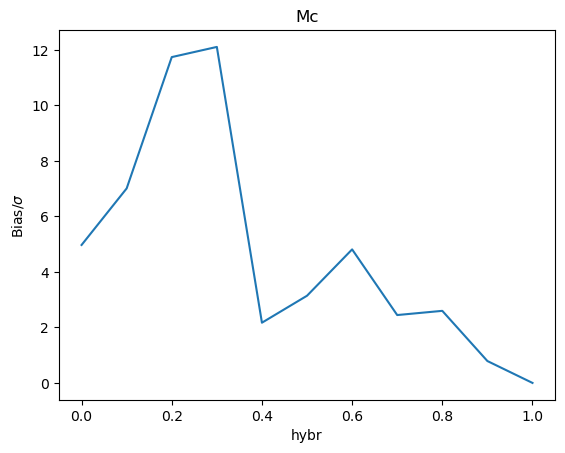

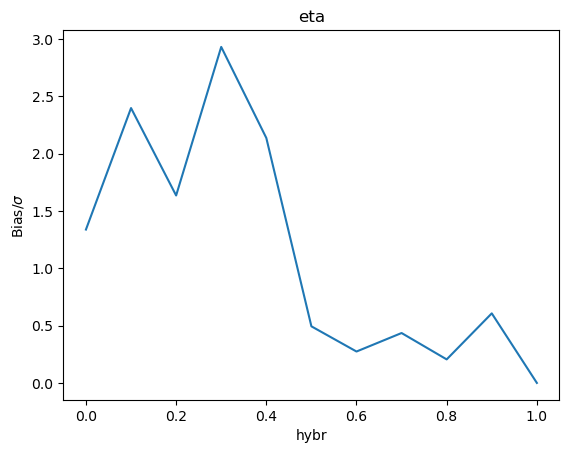

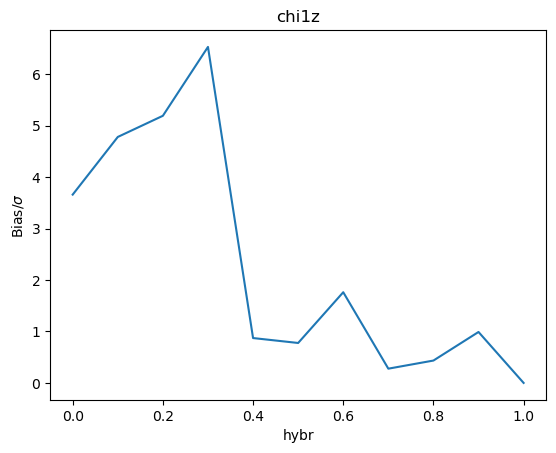

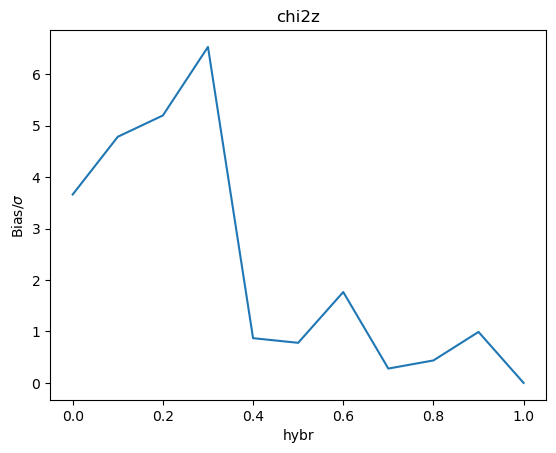

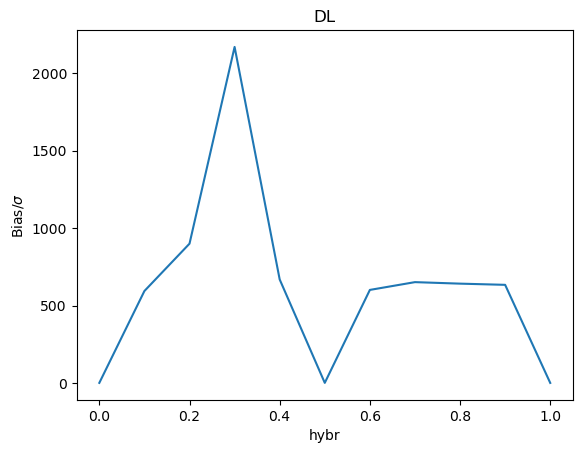

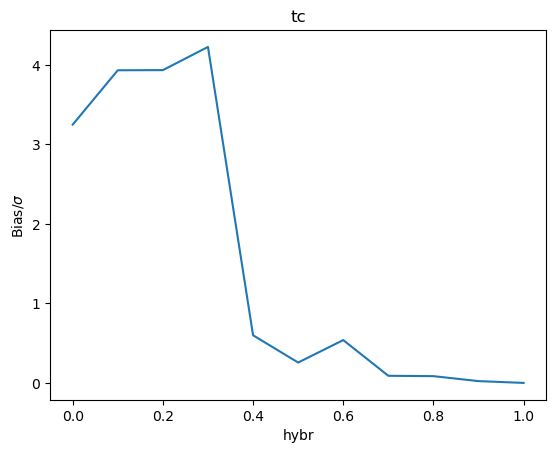

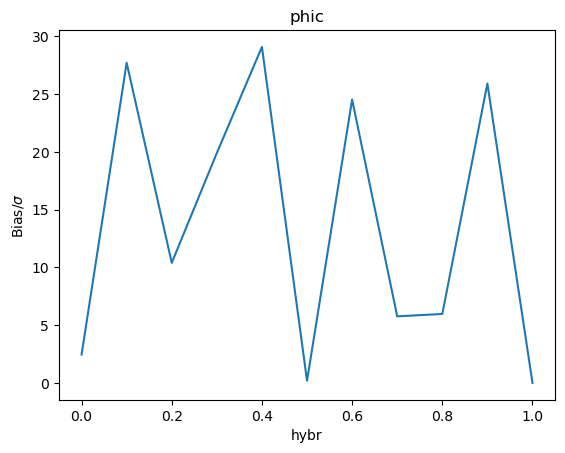

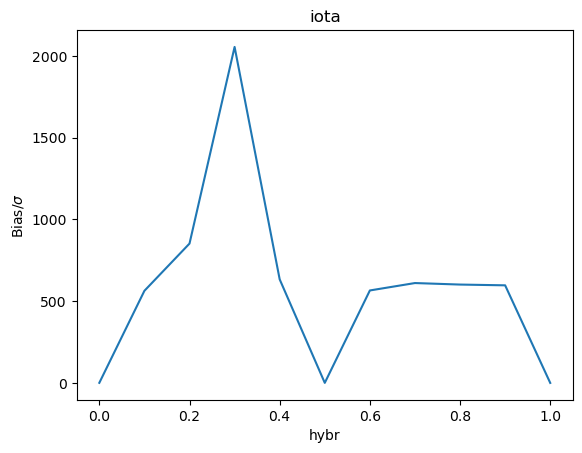

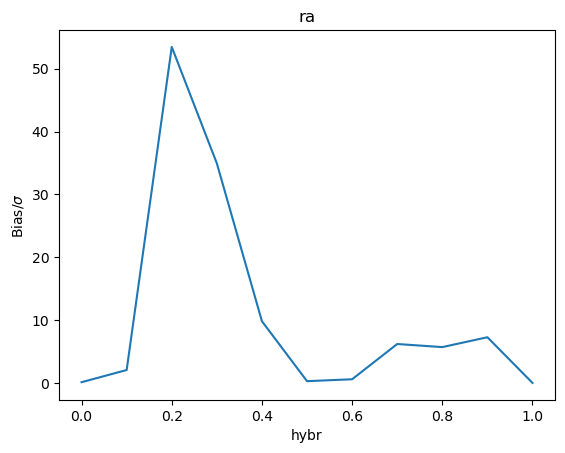

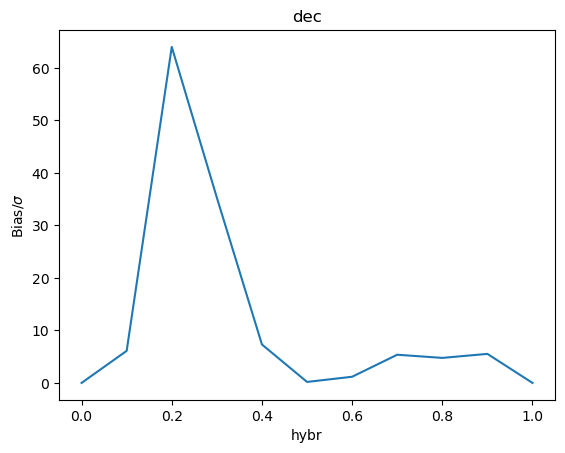

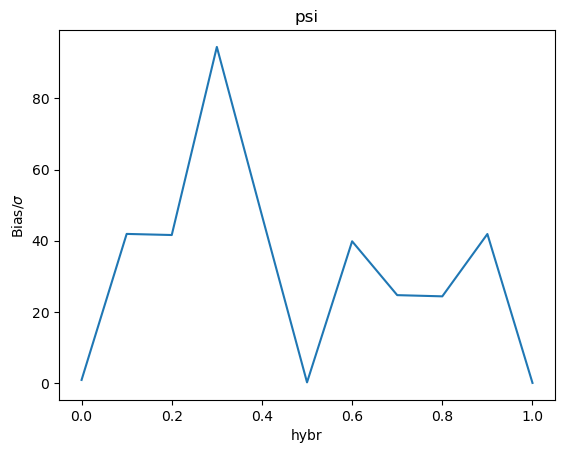

In [73]:
for i, var in enumerate(net_ap.deriv_variables):
    # print(f"def: {net_ap.deriv_variables[i]}: {cv_bias_opt[i]/net_ap.errs[var]:.3f} sigma")

    # for h, hybr in enumerate(hybr_range):
    #     print(f"hybr={hybr:.1f}: {net_ap.deriv_variables[i]}: {cv_bias_opt_hybr_all[h][i]/net_ap.errs[var]:.3f} sigma")
    # print()
    plt.title(var)
    plt.plot(hybr_range, np.abs(cv_bias_opt_hybr_all[:,i]/net_ap.errs[var]))
    plt.xlabel('hybr')
    plt.ylabel('Bias/$\sigma$')
    plt.show()


# Optimize phic, tc by (scipy.optimize) minimizing mismatch

In [3]:
def set_up_waveforms(i, net_key = '3G', approx1 = 'IMRPhenomXAS', approx2 = 'IMRPhenomD'):
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 


    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))

    net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=True)

    delta_f = net_1.f[1] - net_1.f[0]
    psd = FrequencySeries(net_1.detectors[0].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_1.f, net_1.detectors[0].f, assume_unique=True)

    hp1_pyc = FrequencySeries(net_1.hfp[freq_mask], delta_f=delta_f)
    hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)

    return net_1, [inj_params, f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm]


def overlap_func(params, args):
        
        inj_params,f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm  = args

        tc, phic = params

        if (phic>2*np.pi or phic<0.0):
            return +100000
        
        inj_params_opt = inj_params.copy()
        inj_params_opt['tc'] = tc
        inj_params_opt['phic'] = phic

        net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)
        hp2_pyc = FrequencySeries(net_2_try.hfp[freq_mask], delta_f=delta_f)
        hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

        inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm)) # match

        return 1-inner_prod # mismatch



def cv_biases_aligned_misaligned(args2):
    inj_params, tc_opt, phic_opt, approx1, approx2, net_key, f_high = args2

    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc_opt
    inj_params_opt['phic'] = phic_opt

    # compute CV biases with and without aligning the waveforms
    net_2 = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    net_2_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    return net_2, net_2_opt

In [4]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

net_1, args = set_up_waveforms(i, net_key=net_key, approx1=approx1, approx2=approx2)
inj_params, f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm = args


2023-12-05 10:34:05,866 - Network - INFO : Polarizations calculated.
2023-12-05 10:34:05,867 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-05 10:34:06,367 - Network - INFO : Polarizations calculated.
2023-12-05 10:34:35,167 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-05 10:34:35,204 - Network - INFO : PSDs loaded.
2023-12-05 10:34:35,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-05 10:34:37,066 - Network - INFO : Detector responses calculated.
2023-12-05 10:34:37,067 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-05 10:34:37,068 - Network - INFO :    CE-40_C
2023-12-05 10:34:56,991 - Network - INFO :    CE-20_S
2023-12-05 10:35:15,887 - Network - INFO :    ET_ET1
2023-12-05 10:35:33,775 - Network - INFO :    ET_ET2
2023-12-05 10:35:51,499 - Network - INFO :    ET_ET3
2023-12-05 10:36:11,298 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-05 1

In [5]:
initial=[0., 0.]
result = minimize(overlap_func, initial, args=args, method='nelder-mead')
tc_opt, phic_opt = result.x

2023-12-05 10:36:12,367 - Network - INFO : Polarizations calculated.


2023-12-05 10:36:12,766 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:13,166 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:13,567 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:13,966 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:14,366 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:14,866 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:15,166 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:15,566 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:15,866 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:16,267 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:16,666 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:16,967 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:17,467 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:17,866 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:18,267 - Network 

In [6]:
print(result)
print(1-result.fun)
print(tc_opt, phic_opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002535066429893984
             x: [-6.205e-03  1.116e-03]
           nit: 18
          nfev: 34
 final_simplex: (array([[-6.205e-03,  1.116e-03],
                       [-6.186e-03,  1.036e-03],
                       [-6.175e-03,  1.194e-03]]), array([ 2.535e-04,  2.549e-04,  2.630e-04]))
0.9997464933570106
-0.006205184936523438 0.0011163215637207038


In [7]:
args2 = [inj_params, tc_opt, phic_opt, approx1, approx2, net_key, f_high]
net_no_opt, net_opt = cv_biases_aligned_misaligned(args2)
cv_biases_no_opt = net_no_opt.cutler_vallisneri_bias.tolist()[0]
cv_biases_opt = net_opt.cutler_vallisneri_bias.tolist()[0]

2023-12-05 10:36:27,568 - Network - INFO : Polarizations calculated.
2023-12-05 10:36:27,569 - Network - INFO : Calculate numeric derivatives of polarizations.


2023-12-05 10:36:28,468 - Network - INFO : Polarizations calculated.
2023-12-05 10:37:19,304 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-05 10:37:19,408 - Network - INFO : PSDs loaded.
2023-12-05 10:37:19,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-05 10:37:24,068 - Network - INFO : Detector responses calculated.
2023-12-05 10:37:24,070 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-05 10:37:24,070 - Network - INFO :    CE-40_C
2023-12-05 10:38:02,880 - Network - INFO :    CE-20_S
2023-12-05 10:38:40,582 - Network - INFO :    ET_ET1
2023-12-05 10:39:18,372 - Network - INFO :    ET_ET2
2023-12-05 10:39:55,281 - Network - INFO :    ET_ET3
2023-12-05 10:40:35,092 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-05 10:40:35,095 - Network - INFO : SNRs calculated.
2023-12-05 10:40:35,096 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-12-05 10:40:35,096 - N

faithfulness before aligning: 0.7074812990832565
faithfulness after aligning: 0.9997464933570102


/home/vkapil1/.conda/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


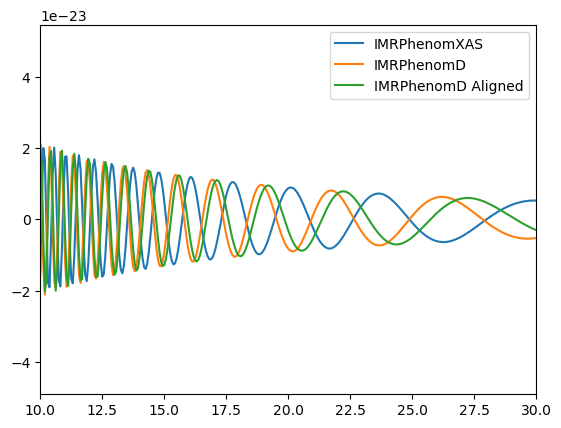

In [8]:
hp2_pyc = FrequencySeries(net_no_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod_no_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

hp2_pyc = FrequencySeries(net_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

print("faithfulness before aligning:", inner_prod_no_opt)
print("faithfulness after aligning:", inner_prod_opt)

plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
plt.plot(net_no_opt.f, net_no_opt.hfp, label='IMRPhenomD')
plt.plot(net_opt.f, net_opt.hfp, label='IMRPhenomD Aligned')

plt.xlim(10, 30)
plt.legend()
plt.show()


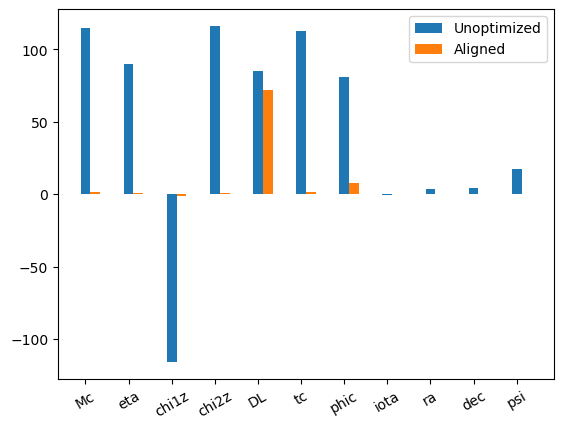

Mc, not: 114.599 sigma
Mc, opt: 1.384 sigma

eta, not: 89.637 sigma
eta, opt: 1.010 sigma

chi1z, not: -116.039 sigma
chi1z, opt: -1.009 sigma

chi2z, not: 116.118 sigma
chi2z, opt: 0.684 sigma

DL, not: 84.996 sigma
DL, opt: 71.713 sigma

tc, not: 112.933 sigma
tc, opt: 1.346 sigma

phic, not: 81.019 sigma
phic, opt: 7.569 sigma

iota, not: -0.406 sigma
iota, opt: 0.008 sigma

ra, not: 3.735 sigma
ra, opt: 0.140 sigma

dec, not: 3.986 sigma
dec, opt: 0.133 sigma

psi, not: 17.460 sigma
psi, opt: 0.428 sigma



In [9]:
err_no_opt = np.zeros(len(cv_biases_no_opt))
err_opt = np.zeros(len(cv_biases_opt))


for i, param in enumerate(net_opt.deriv_variables):
    err_no_opt[i] = net_no_opt.errs[param]
    err_opt[i] = net_opt.errs[param]


x = np.linspace(0, len(cv_biases_opt), len(cv_biases_opt))

width = 0.25
plt.bar(x, cv_biases_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, cv_biases_opt/err_opt, width=width, label='Aligned')

plt.xticks(x, net_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

for i, param in enumerate(net_opt.deriv_variables):
    bias1 = cv_biases_no_opt[i]/net_no_opt.errs[param]
    bias2 = cv_biases_opt[i]/net_opt.errs[param]
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()